In [28]:
# from sklearn.neural_network import MLPRegressor
import numpy as np
# Initial imports
import pandas as pd
from pathlib import Path
import hvplot.pandas
import holoviews as hv
from itertools import islice
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Pull in and GMA Data

In [2]:
data_csv = pd.read_csv(Path("./GMA_data.csv"))
data_csv = data_csv.drop(columns=['% Change', '% Change.1', 'MOI 11/2022',
       'MOI 11/2023', '% Change.2' , '% Change.3', 'Geo Market Area'])
data_csv.head()


,ASP 12/2021 - 12/2022,ASP 12/2022 - 12/2023,Transactions 12/2021 - 12/2022,Transactions 12/2022 - 12/2023,Avg DOM 12/2021 - 12/2022,Avg DOM 12/2022 - 12/2023
0,"$305,022","$319,320",290,205.0,15.0,35.7
1,"$321,283","$331,624",411,245.0,27.6,39.2
2,"$265,879","$258,609",786,613.0,23.3,40.2
3,"$237,692","$237,042",880,755.0,23.2,38.1
4,"$260,950","$262,756",523,443.0,21.8,31.6


In [3]:
data_csv.dtypes

ASP 12/2021 - 12/2022              object
ASP 12/2022 - 12/2023              object
Transactions 12/2021 - 12/2022      int64
Transactions 12/2022 - 12/2023    float64
Avg DOM 12/2021 - 12/2022         float64
Avg DOM 12/2022 - 12/2023         float64
dtype: object

In [4]:
data_csv.columns

Index(['ASP 12/2021 - 12/2022', 'ASP 12/2022 - 12/2023',
       'Transactions 12/2021 - 12/2022', 'Transactions 12/2022 - 12/2023',
       'Avg DOM 12/2021 - 12/2022', 'Avg DOM 12/2022 - 12/2023'],
      dtype='object')

In [5]:
H_data= pd.read_csv(Path("./Houston_data.csv"),skiprows=1)
H_data = H_data.drop(columns=['Property Type','Year Ago.1', 'Year Ago.2','Year Ago.3', 'Price.1'])
H_data.dropna(inplace=True)
H_data.head()                   

,Listings*,Year Ago,Dollar Volume,Price
1,"7,983",-4%,"$3,353,852,000","$420,124"
2,556,-19%,"$145,065,478","$260,909"
3,65,-22%,"$31,514,889","$484,844"
4,244,-10%,"$142,090,041","$582,336"
5,73,30%,"$35,446,505","$485,569"


In [6]:
H_data.columns

Index(['Listings*', 'Year Ago', 'Dollar Volume', 'Price'], dtype='object')

In [7]:
H_data.dtypes

Listings*        object
Year Ago         object
Dollar Volume    object
Price            object
dtype: object

In [8]:
Dom_data = pd.read_csv(Path("./Days_on_market.csv"),skiprows=1)
Dom_data=Dom_data.drop(columns=['Year Ago','Year Ago.1', 'Year Ago.2', 'Listings.1','Listings.2', 'Year Ago.3','Year Ago.4','Property Type','DOM'])
Dom_data.dropna(inplace=True)
Dom_data.head()

,Sqft*,Listings
1,$175,"62,184"
2,$167,"4,559"
3,$171,541
4,$397,"1,932"
5,$310,583


In [9]:
Dom_data.dtypes

Sqft*       object
Listings    object
dtype: object

In [10]:
Historic_pricing = pd.read_csv(Path("./Historic_pricing.csv"),skiprows=1)
Historic_pricing= Historic_pricing.drop(columns=['Listings*','Price.1', 'Listings.1', 'Listings.2', 'Orig. List Price','Price','Listings'])
Historic_pricing.dropna(inplace=True)
Historic_pricing.head()

,Year,Month,Sqft,DOM
0,2021,Jan,$132,43
1,2021,Feb,$139,42
2,2021,Mar,$143,39
3,2021,Apr,$148,33
4,2021,May,$152,28


In [11]:
Housing_report = pd.concat([H_data,Dom_data,Historic_pricing],axis=1)
Housing_report=Housing_report.drop(columns=['Sqft*', 'Listings*', 'Month'])
Housing_report.dropna(inplace=True)

Housing_report.head()
def convert_percentage_to_float(x):
    if isinstance(x, str):
        return float(x.strip('%')) / 100
    return x
for column in Housing_report:
    Housing_report[column] = pd.to_numeric(Housing_report[column].replace('[\$,]', '', regex=True), errors='coerce')


Housing_report['Dollar Volume'] = pd.to_numeric(Housing_report['Dollar Volume'].replace('[\$,]', '', regex=True), errors='coerce')
Housing_report['Price'] = pd.to_numeric(Housing_report['Price'].replace('[\$,]', '', regex=True), errors='coerce')
Housing_report['Sqft'] = pd.to_numeric(Housing_report['Sqft'].replace('[\$,]', '', regex=True), errors='coerce')

# Handle NaN values (example: fill with 0 or mean, or drop)
Housing_report.fillna(0, inplace=True)  # or df.dropna(inplace=True)

# Check the data types and convert if necessary
Housing_report['Year'] = Housing_report['Year'].astype(int)
Housing_report['Year Ago'] = Housing_report['Year Ago'].apply(convert_percentage_to_float)
#Housing_report['Dollar Volume'] = pd.to_numeric(Housing_report['Dollar Volume'], errors='coerce')
# Housing_report['Price'] = pd.to_numeric(Housing_report['Price'], errors='coerce')
#Housing_report['Sqft'] = pd.to_numeric(Housing_report['Sqft'], errors='coerce')
#Housing_report['Listings'] = pd.to_numeric(Housing_report['Listings'], errors='coerce')


In [12]:
Housing_report.head()

,Year Ago,Dollar Volume,Price,Listings,Year,Sqft,DOM
1,0.0,3353852000,420124,62184,2021,139,42
2,0.0,145065478,260909,4559,2021,143,39
3,0.0,31514889,484844,541,2021,148,33
4,0.0,142090041,582336,1932,2021,152,28
5,0.0,35446505,485569,583,2021,155,24


In [13]:
Housing_report.columns

Index(['Year Ago', 'Dollar Volume', 'Price', 'Listings', 'Year', 'Sqft',
       'DOM'],
      dtype='object')

In [14]:
Housing_report.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28 entries, 1 to 30
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year Ago       28 non-null     float64
 1   Dollar Volume  28 non-null     int64  
 2   Price          28 non-null     int64  
 3   Listings       28 non-null     int64  
 4   Year           28 non-null     int32  
 5   Sqft           28 non-null     int64  
 6   DOM            28 non-null     int64  
dtypes: float64(1), int32(1), int64(5)
memory usage: 1.6 KB


In [15]:
correlation_matrix = Housing_report.corr()

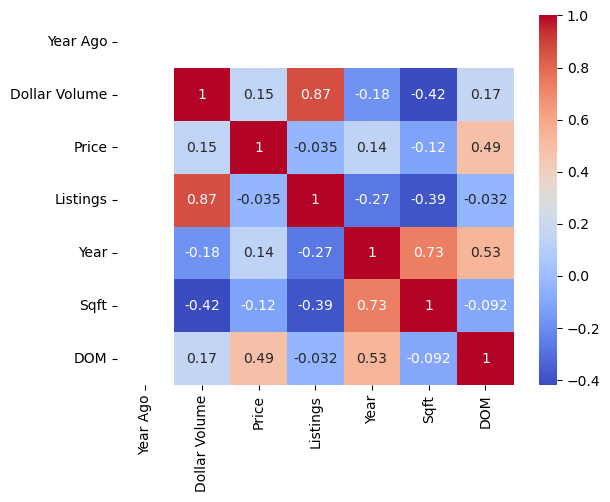

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Assuming Housing_report is your dataframe and 'Price' is the column you want to predict
target = Housing_report['Price']
features = Housing_report.drop(columns='Price')

# Splitting the dataset into training and testing sets
training_features, testing_features, training_targets, testing_targets = train_test_split(features, target, test_size=0.2, random_state=7)

# Create a Linear Regression model
linear_regression_model = LinearRegression()

# Fit the model on the training data
lr_model = linear_regression_model.fit(training_features, training_targets)

# Make predictions using the testing set
testing_predictions = lr_model.predict(testing_features)

# Review the predictions and evaluate the model
print(testing_predictions)

# Evaluate the model's performance
mse = mean_squared_error(testing_targets, testing_predictions)
r2 = r2_score(testing_targets, testing_predictions)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


[433624.05385435 459872.2829175  525265.0560801  123023.53128493
 130736.04703414  68000.68839777]
Mean Squared Error: 50771673445.017555
R-squared: -0.5997615018040638


In [18]:
X = Housing_report.drop(columns=['Year Ago']).copy()
X.head()


,Dollar Volume,Price,Listings,Year,Sqft,DOM
1,3353852000,420124,62184,2021,139,42
2,145065478,260909,4559,2021,143,39
3,31514889,484844,541,2021,148,33
4,142090041,582336,1932,2021,152,28
5,35446505,485569,583,2021,155,24


In [24]:
y = Housing_report["DOM"]
y[:5]

1    42
2    39
3    33
4    28
5    24
Name: DOM, dtype: int64

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [29]:
X_scaler = StandardScaler()

In [30]:
X_scaler.fit(X_train)

StandardScaler()

In [31]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [32]:
# Define the the number of inputs to the model
number_inputs = X_train.shape[1]

# Define the number of hidden nodes for the model
number_hidden_nodes = 12

# Create the Sequential model instance
neuron = Sequential([
    Dense(number_hidden_nodes, input_shape=(number_inputs,), activation='relu'),
    Dense(1, activation='linear')  # or another activation function appropriate for your task
])

In [33]:
neuron.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                84        
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 97 (388.00 Byte)
Trainable params: 97 (388.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
neuron.compile(optimizer='adam', loss='mean_squared_error')

In [35]:
model = neuron.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100

1/1 [==============================] - 1s 699ms/step - loss: 1163.3821
Epoch 2/100
1/1 [==============================] - 0s 12ms/step - loss: 1162.7272
Epoch 3/100
1/1 [==============================] - 0s 11ms/step - loss: 1162.0742
Epoch 4/100
1/1 [==============================] - 0s 0s/step - loss: 1161.4211
Epoch 5/100
1/1 [==============================] - 0s 10ms/step - loss: 1160.7673
Epoch 6/100
1/1 [==============================] - 0s 0s/step - loss: 1160.1136
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 1159.4602
Epoch 8/100
1/1 [==============================] - 0s 0s/step - loss: 1158.8088
Epoch 9/100
1/1 [==============================] - 0s 0s/step - loss: 1158.1569
Epoch 10/100
1/1 [==============================] - 0s 8ms/step - loss: 1157.5040
Epoch 11/100
1/1 [==============================] - 0s 8ms/step - loss: 1156.8517
Epoch 12/100
1/1 [==============================] - 0s 9ms/step - loss: 1156.2002
Epoch 13/100
1/1 [=====

In [36]:
model_plot = pd.DataFrame(model.history, index=range(1, len(model.history["loss"]) + 1))

In [37]:
model_plot.head(3)

,loss
1,1163.382080
2,1162.727173
3,1162.074219


<Axes: >

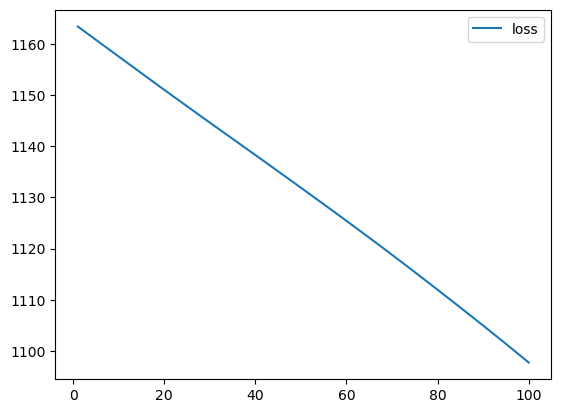

In [38]:
model_plot.plot(y="loss")

In [19]:
# target = Housing_report['Price']
# features = Housing_report.drop(columns='Price')

In [20]:
# training_features, testing_features, training_targets, testing_targets = train_test_split(features, target)

In [21]:
# logistic_regression_model = LogisticRegression(random_state=7)

In [22]:
# lr_model = logistic_regression_model.fit(training_features, training_targets)

In [23]:
# testing_predictions = lr_model.predict(testing_features)

# # Review the predictions
# testing_predictions